<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Transfer_Learning_in_TensorFlow_Feature_Extraction_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problems.

There are two main benifits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## What we're going to cover

* Introduce transfer learning with TensorFlow
* Using a small dataset to experiment faster (10% of training samples)
* Building a transfer learning feature extraction model with TensoFlow Hub
* Use TensorBoard to track modelling experiments and results

## Let's Cook!

In [1]:
# Are we using a GPU?
!nvidia-smi

Wed Mar  6 11:02:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

**Dataset:** [*Food-101 Kaggle*](https://www.kaggle.com/datasets/dansbecker/food-101)

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close() # close the zip file after extracting it

--2024-03-06 11:02:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.207, 74.125.69.207, 64.233.181.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   190MB/s    in 0.8s    

2024-03-06 11:02:06 (190 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [13]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

# Rescaling our data
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print(f"Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                                 target_size=IMAGE_SHAPE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical')

print(f"\nTesting images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical')


Training images:
Found 750 images belonging to 10 classes.

Testing images:
Found 2500 images belonging to 10 classes.


In [14]:
# Let's visualize our image with a helper function
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  '''
  View a random image from a target directory and class
  '''
  # Setup target directory (we'll view images from here)
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f'Image Shape: {img.shape}') # show the shape of the image

  return img


Image Shape: (512, 512, 3)


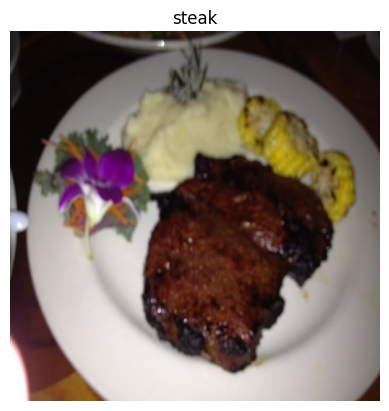

In [15]:
img = view_random_image(target_dir='10_food_classes_10_percent/train/',
                  target_class='steak')

## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the tensorboard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [16]:
# Create TensorBoard callback (Functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):

  '''
  Creates a TensorBoard callback instance to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  '''
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f"Saving TensorBoard log files to: {log_dir}")

  return tensorboard_callback


🔑 **Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved ti whatever you like. The log_dir parameter we've created above is only one option.

## Creating models using TensorFlow Hub (Now merged with Kaggle)

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: [TensorFlow-Hub](https://www.kaggle.com/models)

Also visit [paperswithcode](https://paperswithcode.com/sota)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following vector model link: [EfficientNet-V2-B0](https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2)

So, let's get started.

In [17]:
# Let's compare the following two models
resnet_url = 'https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/101-classification/versions/2'

efficientnet_url = 'https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2'


In [18]:
# Import dependancies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [19]:
# Let's make a create_model() function to create a model from the URL
def create_model(model_url, num_classes=10):

  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor layer
    and Dense output layer with num_classes outputs.
  '''

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax', name='output_layer')
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [20]:
# Create ResNet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data.num_classes)


In [21]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1001)              44677609  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                10020     
                                                                 
Total params: 44687629 (170.47 MB)
Trainable params: 10020 (39.14 KB)
Non-trainable params: 44677609 (170.43 MB)
_________________________________________________________________


In [22]:
# Compile our ResNet model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [23]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                         experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet_model/20240306-115331
Epoch 1/10
24/24 [==============================] - 30s 803ms/step - loss: 2.4232 - accuracy: 0.3533 - val_loss: 1.1974 - val_accuracy: 0.5992
Epoch 2/10
24/24 [==============================] - 15s 645ms/step - loss: 1.0170 - accuracy: 0.7040 - val_loss: 0.8726 - val_accuracy: 0.7004
Epoch 3/10
24/24 [==============================] - 16s 664ms/step - loss: 0.7191 - accuracy: 0.7733 - val_loss: 0.7708 - val_accuracy: 0.7424
Epoch 4/10
24/24 [==============================] - 24s 1s/step - loss: 0.5523 - accuracy: 0.8267 - val_loss: 0.7428 - val_accuracy: 0.7472
Epoch 5/10
24/24 [==============================] - 24s 1s/step - loss: 0.4392 - accuracy: 0.8693 - val_loss: 0.7213 - val_accuracy: 0.7572
Epoch 6/10
24/24 [==============================] - 16s 682ms/step - loss: 0.3627 - accuracy: 0.8920 - val_loss: 0.7184 - val_accuracy: 0.7596
Epoch 7/10
24/24 [==============================] - 16s 682ms/step - lo

That is way better than the results we got in the last notebook using CNN, i.e: Our transfer learning feature extractor model outperformed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [30]:
# Let's plot the loss and accuracy curves
def loss_acc_curves(history):

  '''
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  '''

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))
  plt.figure(figsize=(15, 7))

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show();


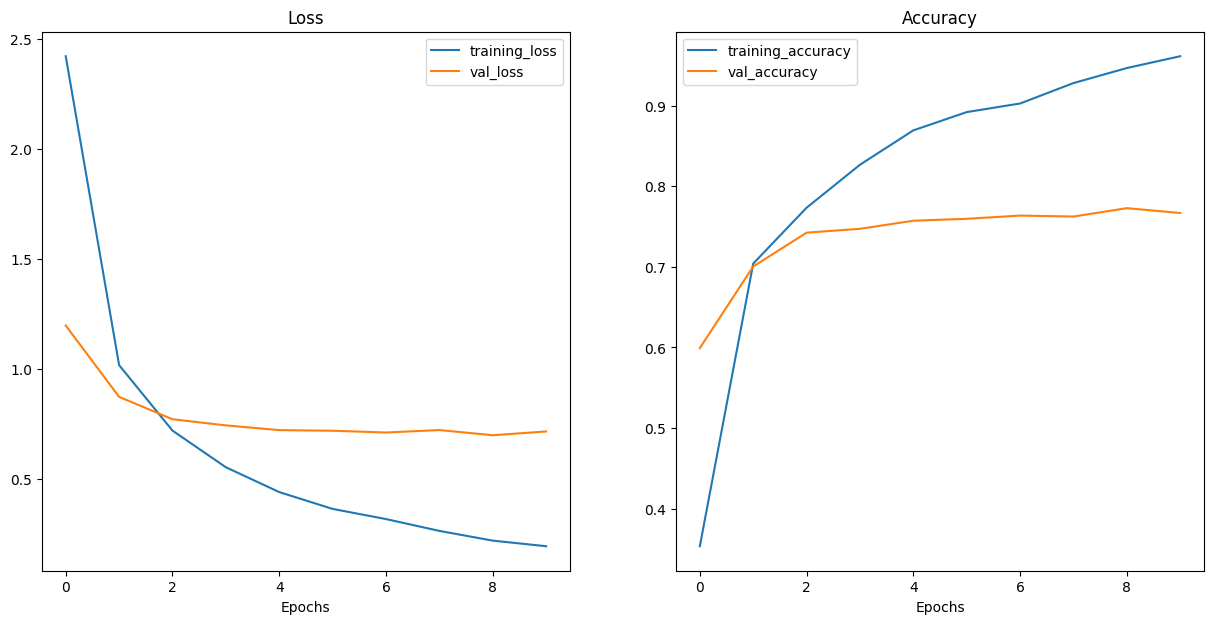

In [31]:
# Plotting the loss_acc curves using the above helper function
loss_acc_curves(resnet_history)
